# Data cleaning and description

In [56]:
#%%capture
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle 
import networkx as nx
from dataloader import *
from tqdm import tqdm

Import data as a panda dataframe

In [65]:
dataset = CitationDataset()
df = dataset.load_dataframe()


loading dataframe from cache c:\Users\Naja-\Documents\GitHub\02807_project/DATA/dblp-ref
loading c:\Users\Naja-\Documents\GitHub\02807_project/DATA/dblp-ref/dblp-ref-3.json
loading c:\Users\Naja-\Documents\GitHub\02807_project/DATA/dblp-ref/dblp-ref-2.json
loading c:\Users\Naja-\Documents\GitHub\02807_project/DATA/dblp-ref/dblp-ref-1.json
loading c:\Users\Naja-\Documents\GitHub\02807_project/DATA/dblp-ref/dblp-ref-0.json


Number of papers: 3079007


<Axes: >

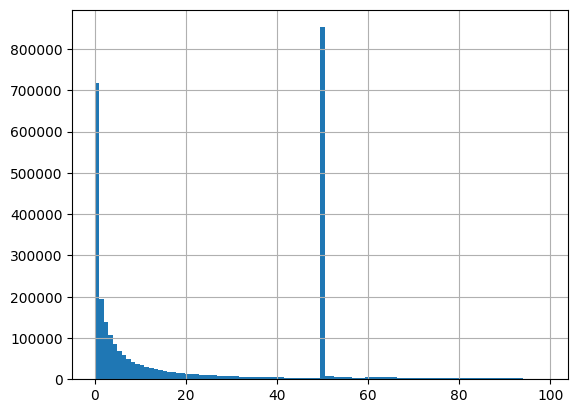

In [66]:
print('Number of papers: {}'.format(len(df)))
df['n_citation'].hist(bins=100, range=(0, 99))

We see that the most commen number of citations are 50? (weirdly enough)

In [67]:
df['n_citation'].describe()


count    3.079007e+06
mean     3.522090e+01
std      1.577007e+02
min      0.000000e+00
25%      1.000000e+00
50%      1.100000e+01
75%      5.000000e+01
max      7.336200e+04
Name: n_citation, dtype: float64

In [68]:
print('Number of papers with 0 citations: {}'.format(len(df[df['n_citation'] == 0])))
print('Max citations: {}'.format(df['n_citation'].max()))
print('Mean citations: {}'.format(df['n_citation'].mean()))

Number of papers with 0 citations: 718250
Max citations: 73362
Mean citations: 35.220902713114974


Now we delete all papers with 0 and 50 citations

In [69]:
df = df[(df[['abstract']] != '').all(axis=1)]
df = df[(df[['n_citation']] != 0).all(axis=1)]
df = df[(df[['n_citation']] != 50).all(axis=1)]


In [70]:
df.head()

,abstract,authors,n_citation,references,title,venue,year,id
55,Structured regression has been successfully us...,"[Fang Zhou, Mohamed F. Ghalwash, Zoran Obradovic]",1,"[05747537-ec32-4428-bb6a-adc8613e17c3, 05dc4e2...",A fast structured regression for large networks,,2016,0b6b0cc7-4397-480e-9ec6-5cac94c2aa11
162,The Post-PC revolution is bringing information...,"[Steven J. Ross, Jason L. Hill, Michael Chen, ...",63,"[2ee9a087-6188-4ebd-95b9-6561cba0584c, 3a16c8d...",A composable framework for secure multi-modal ...,Mobile Networks and Applications,2002,27c5ea64-86cb-4e69-9d13-c8ba2654515d
299,The problem of motion planning in three dimens...,"[Susan Hert, Vladimir J. Lumelsky]",5,"[040688b7-9070-4af4-a4ee-5d45175b58a4, 1bd5c32...",Motion planning in R 3 for multiple tethered r...,intelligent robots and systems,1997,4954b769-6ae1-44d5-94d3-92f0e9d33401
358,Many recently proposed graph-processing framew...,"[Bryan Rainey, David F. Gleich]",1,"[071ee610-d8d2-436d-a000-ec09fc4b1731, 0b0fc98...",Massive graph processing on nanocomputers,,2016,5907e2ce-35ae-4ce3-970f-aedb0fe3d3bb
401,The haplotype resolution from xor-genotype dat...,"[Paola Bonizzoni, Gianluca Della Vedova, Ricca...",7,"[33271a83-8a83-4048-bad8-ba05cdd31da6, 56e357b...",Pure Parsimony Xor Haplotyping,international symposium on bioinformatics rese...,2009,686101d0-513f-4aa5-b959-d09e8aff04ab


In [71]:
print('Number of papers: {}'.format(len(df)))
print('Mean citations: {}'.format(df['n_citation'].mean()))
df['n_citation'].describe()


Number of papers: 1297860
Mean citations: 46.46594624998074


count    1.297860e+06
mean     4.646595e+01
std      2.320536e+02
min      1.000000e+00
25%      3.000000e+00
50%      1.000000e+01
75%      3.800000e+01
max      7.336200e+04
Name: n_citation, dtype: float64

<Axes: >

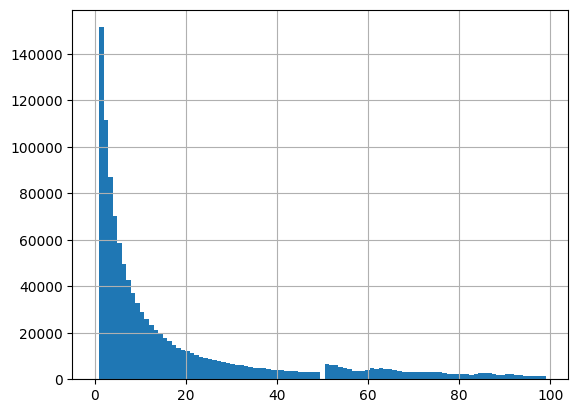

In [73]:
df['n_citation'].hist(bins=100, range=(0, 99))

The histogram looks like it could follow a power-law, eventhough we see a tendency for slightly more citations after 50 citations, which could be something related to the many 50 citation

Load graph

In [114]:
def load_graph(df):
    """
    Loads networkx DiGraph from dataframe.
    """
    # Create an empty directed graph
    G = nx.DiGraph()
    
    # Create a set of all the paper IDs
    id_set = set(df['id'])
    
    # Iterate through the DataFrame and add nodes and edges to the graph
    for _, row in tqdm(df.iterrows(), total=len(df)):
        node_id = row.id
        references = row.references

        # Add the node to the graph
        G.add_node(
            node_id,
            abstract=row.abstract,
            authors=row.authors,
            n_citation=row.n_citation,
            title=row.title,
            venue=row.venue,
            year=row.year,
        )
        
        # Add edges from the node to its references
        for reference in references:
            if reference in id_set:
                G.add_edge(node_id, reference)

    return G

In [91]:
if '0b6b0cc7-4397-480e-9ec6-5cac94c2aa11' in df['id'].values:
    print('True')
else:
    print('False')


True


In [111]:
len(set(df['id'].values))


1297860

In [115]:
G = load_graph(df)
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())
pickle.dump(G, open( "base_graph.pkl", "wb" ) )


100%|██████████| 1297860/1297860 [03:23<00:00, 6370.39it/s]


Number of nodes:  1297860
Number of edges:  10365410


In [ ]:
## Here you open the pickle file to load the graph
with open("base_graph.pkl", 'rb') as f:
    G = pickle.load(f)